In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numbers import Number
from collections import Counter

In [2]:
def _df_colors(val):
    """
    Функция для более выделяющихся цветов в датафреймах
    """
    if isinstance(val, bool) and val is False:
        color = "red"
    elif isinstance(val, bool) and val is True:
        color = "limegreen"
    elif isinstance(val, Number):
        # color = "gold"
        color = "mediumspringgreen"
    else:
        color = "cornflowerblue"
    return "color: %s" % color

In [81]:
F0df = pd.read_csv("F0df.csv", sep=",", index_col=0)

In [82]:
F0df.head().style.map(_df_colors)

In [5]:
for k, v in Counter(list(F0df["Emotion Class"])).items():
    print(f"{k:>2}: {v}")

 1: 9
 2: 2
 3: 15
 4: 3
 5: 1
 9: 1
10: 1094


In [62]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

# One class SVM classification

In [6]:
# Synthetic dataset
from sklearn.datasets import make_classification

# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
# Create an imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)
# Convert the data from numpy array to a pandas dataframe
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})
# Check the target distribution
df['target'].value_counts(normalize = True)

target
0    0.9897
1    0.0103
Name: proportion, dtype: float64

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 80000
The number of records in the test dataset is 20000
The training dataset has 79183 records for the majority class and 817 records for the minority class.


In [9]:
one_class_svm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto').fit(X_train)

In [10]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]
# Check the model performance
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19787
           1       0.06      0.06      0.06       213

    accuracy                           0.98     20000
   macro avg       0.53      0.53      0.53     20000
weighted avg       0.98      0.98      0.98     20000



In [11]:
# Get the scores for the testing dataset
score = one_class_svm.score_samples(X_test)
# Check the score for 2% of outliers
score_threshold = np.percentile(score, 2)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')
# Check the model performance at 2% threshold
customized_prediction = [1 if i < score_threshold else 0 for i in score]
# # Check the prediction performance
print(classification_report(y_test, customized_prediction))

The customized score threshold for 2% of outliers is 182.62
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19787
           1       0.06      0.10      0.07       213

    accuracy                           0.97     20000
   macro avg       0.52      0.54      0.53     20000
weighted avg       0.98      0.97      0.98     20000



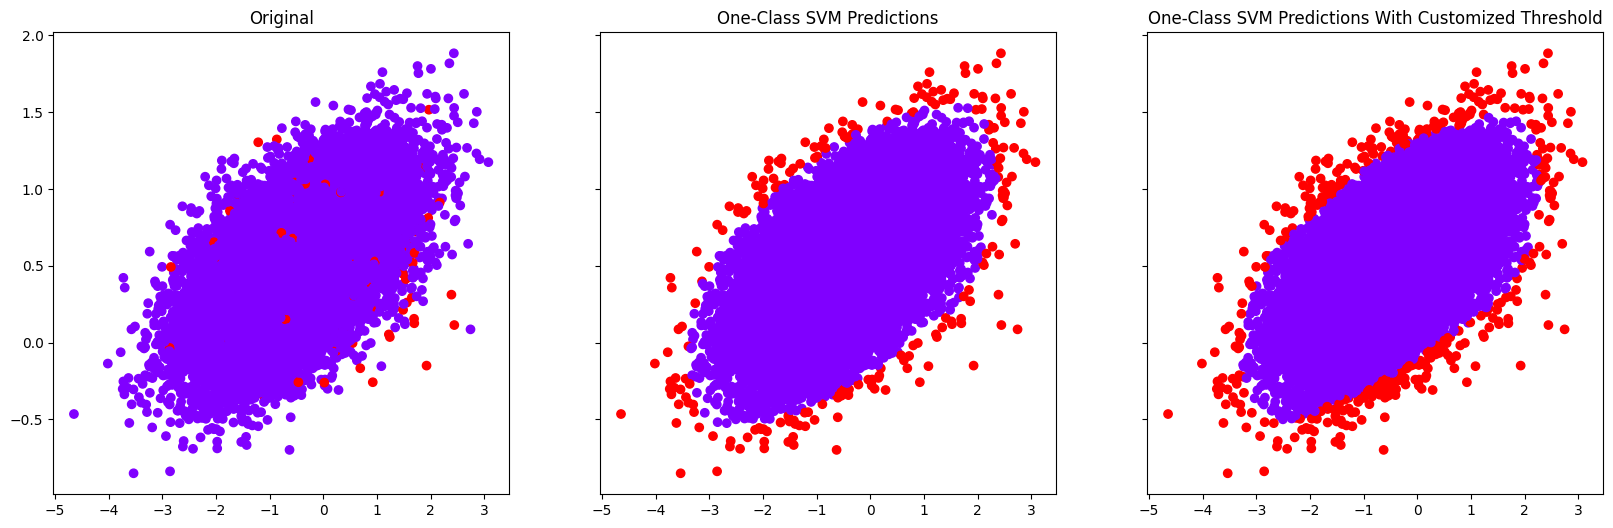

In [12]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = y_test
df_test['one_class_svm_prediction'] = prediction
df_test['one_class_svm_prediction_cutomized'] = customized_prediction
# Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2)=plt.subplots(1,3, sharey=True, figsize=(20,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')
# One-Class SVM Predictions With Customized Threshold
ax2.set_title('One-Class SVM Predictions With Customized Threshold')
ax2.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction_cutomized'], cmap='rainbow');

# F0 data

In [83]:
F0df.loc[F0df["Emotion Class"] < 10, "Emotion Class"] = 0
F0df.loc[F0df["Emotion Class"] == 10, "Emotion Class"] = 1

In [84]:
Counter(F0df["Emotion Class"])

Counter({1: 1094, 0: 31})

In [43]:
31/(1094+31)

0.027555555555555555

In [85]:
F0df.head().style.map(_df_colors)

In [86]:
F0df[F0df.columns[2:]] = std_scaler.fit_transform(F0df[F0df.columns[2:]])
F0df.head().style.map(_df_colors)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(F0df[F0df.columns[2:]], 
                                                    F0df["Emotion Class"], 
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=42)

In [119]:
one_class_svm = OneClassSVM(nu=0.0275, kernel = 'rbf', gamma = 'auto').fit(X_train)

In [120]:
prediction = one_class_svm.predict(X_test)

In [121]:
# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]
# Check the model performance
classification_report(y_test, prediction, output_dict=True)

{'0': {'precision': 0.01875,
  'recall': 0.6,
  'f1-score': 0.03636363636363636,
  'support': 5.0},
 '1': {'precision': 0.9692307692307692,
  'recall': 0.2863636363636364,
  'f1-score': 0.4421052631578948,
  'support': 220.0},
 'accuracy': 0.29333333333333333,
 'macro avg': {'precision': 0.49399038461538464,
  'recall': 0.4431818181818182,
  'f1-score': 0.23923444976076558,
  'support': 225.0},
 'weighted avg': {'precision': 0.9481089743589743,
  'recall': 0.29333333333333333,
  'f1-score': 0.43308878256246686,
  'support': 225.0}}

In [122]:
print(classification_report(y_test, prediction, output_dict=False))

              precision    recall  f1-score   support

           0       0.02      0.60      0.04         5
           1       0.97      0.29      0.44       220

    accuracy                           0.29       225
   macro avg       0.49      0.44      0.24       225
weighted avg       0.95      0.29      0.43       225



# MFCC

In [20]:
import librosa

In [21]:
y, sr = librosa.load(r"C:\Users\Ivan\Desktop\AI\0_Dissertation\emo_audio\0107578611_00__00-channel-0-number-001_3070.wav")

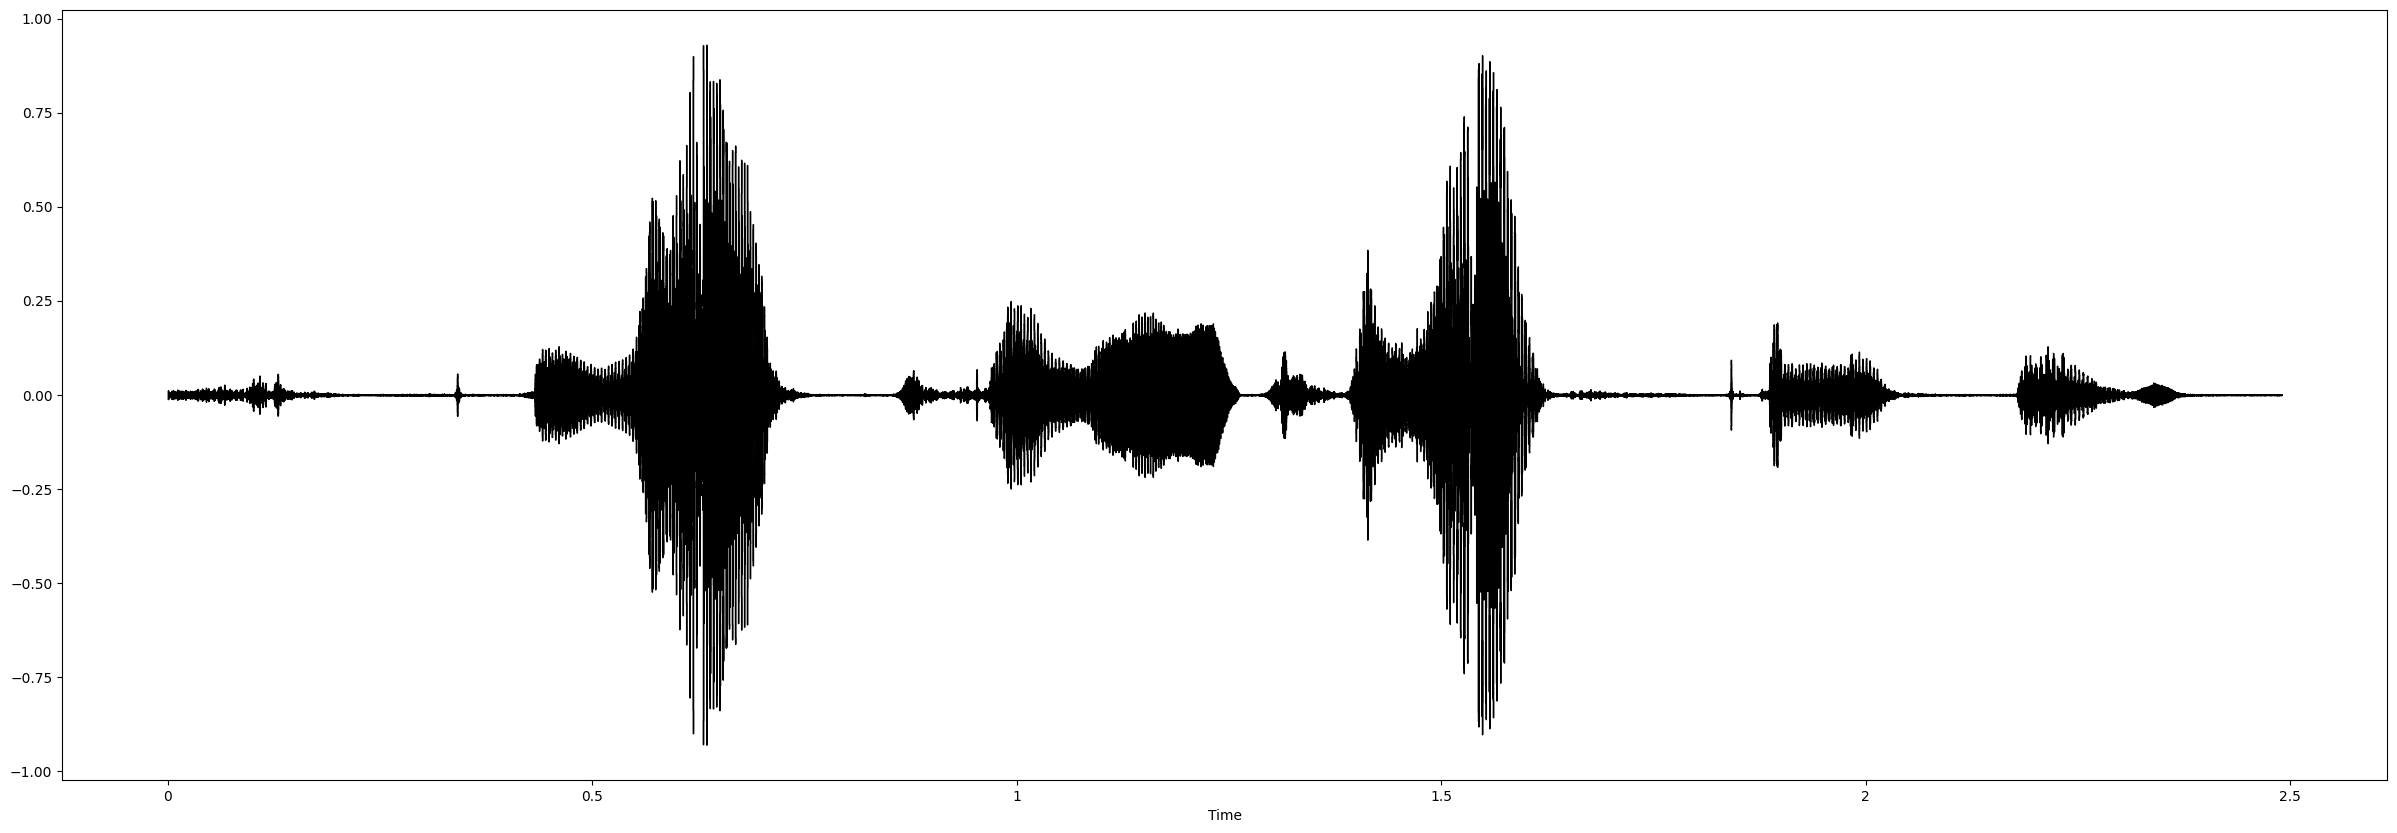

In [22]:
plt.figure(figsize=(30,10))
librosa.display.waveshow(y, sr=sr, color="black");

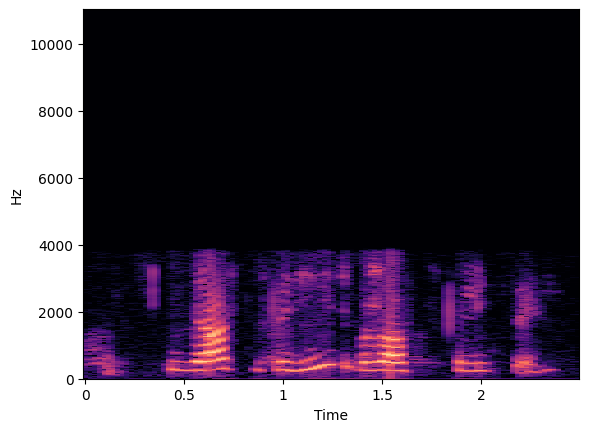

In [23]:
# plt.figure(figsize=(30,10))
D = np.abs(librosa.stft(y))
db = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(db, sr=sr, y_axis='hz', x_axis='time');

In [24]:
frame_width = 20 # ms
frame_step = 10 # ms

print(frame_width := round(frame_width * 0.001 * sr)) # ms to the number of samples
print(frame_step := round(frame_step * 0.001 * sr)) # ms to the number of samples

print(nfft := int(2**np.ceil(np.log2(frame_width)))) # closest upper power of 2 for frame width

441
220
512


In [25]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=nfft, hop_length=frame_step, win_length=frame_width)

In [154]:
MFCCs = {"IDs": list(F0df["IDs"])}
for i in range(13):
    MFCCs[f"MFCC{i+1}"] = []

In [155]:
for i, filename in enumerate(F0df["IDs"]):
# get the time series
    y, sr = librosa.load(rf"C:\Users\Ivan\Desktop\AI\0_Dissertation\emo_audio\{filename}.wav")
# get the coefficients
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=nfft, hop_length=frame_step, win_length=frame_width)
# scale the coefficients
    mfccScaled = np.mean(mfcc.T, axis=0)

    for j in range(len(mfccScaled)):
        MFCCs[f"MFCC{j+1}"].append(mfccScaled[j])

In [156]:
mfccDF = pd.DataFrame(MFCCs)
mfccDF.head().style.map(_df_colors)

,IDs,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,MFCC13
0,0107635181_00__00-channel-0-number-004_18310,-430.050812,151.687164,-45.405285,6.089986,16.060833,-35.592243,-7.429289,-2.388579,-23.355518,-7.821520,-13.513171,-17.238529,2.689556
1,0107635181_00__00-channel-0-number-005_22100,-408.129059,156.219803,-50.914352,7.203946,17.909063,-39.309731,-9.709213,-2.864349,-24.096661,-5.696147,-9.311288,-14.882713,2.547493
2,0107635181_00__00-channel-0-number-006_26690,-420.051056,156.462692,-51.804707,14.146825,21.260660,-43.143650,-10.840601,-2.410405,-26.338383,-8.020977,-9.845235,-13.113922,4.449926
3,0107642521_02__00-channel-0-number-012_39570,-466.652832,139.322784,-49.670067,6.194052,20.342075,-30.037249,-5.130371,-2.447774,-24.319750,-5.400891,-5.272196,-16.889706,-9.205757
4,0107649291_00__00-channel-0-number-016_55040,-441.062592,173.835739,-58.788204,4.886978,17.059248,-34.680538,2.012652,-1.799171,-19.657211,10.577251,-7.337635,-20.489962,7.810188


In [157]:
mfccDF[mfccDF.columns[1:]] = std_scaler.fit_transform(mfccDF[mfccDF.columns[1:]])
mfccDF.head().style.map(_df_colors)

,IDs,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,MFCC13
0,0107635181_00__00-channel-0-number-004_18310,0.674096,-0.571180,-0.724597,-0.398179,-0.375483,-0.761350,-0.223855,0.293519,0.094525,-0.789816,-1.741961,-0.326997,0.780956
1,0107635181_00__00-channel-0-number-005_22100,1.159927,-0.331894,-0.980339,-0.314185,-0.190747,-1.175419,-0.507318,0.224022,-0.024537,-0.426525,-0.855243,0.183726,0.747198
2,0107635181_00__00-channel-0-number-006_26690,0.895711,-0.319072,-1.021671,0.209312,0.144256,-1.602456,-0.647984,0.290331,-0.384661,-0.823910,-0.967921,0.567187,1.199269
3,0107642521_02__00-channel-0-number-012_39570,-0.137080,-1.223915,-0.922577,-0.390332,0.052440,-0.142612,0.061970,0.284873,-0.060375,-0.376056,-0.002878,-0.251375,-2.045705
4,0107649291_00__00-channel-0-number-016_55040,0.430052,0.598079,-1.345859,-0.488886,-0.275688,-0.659800,0.950064,0.379616,0.688643,2.355100,-0.438745,-1.031884,1.997762


In [158]:
mfccDF = pd.merge(F0df[F0df.columns[:2]], mfccDF)
mfccDF.head().style.map(_df_colors)

,IDs,Emotion Class,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,MFCC13
0,0107635181_00__00-channel-0-number-004_18310,0,0.674096,-0.571180,-0.724597,-0.398179,-0.375483,-0.761350,-0.223855,0.293519,0.094525,-0.789816,-1.741961,-0.326997,0.780956
1,0107635181_00__00-channel-0-number-005_22100,0,1.159927,-0.331894,-0.980339,-0.314185,-0.190747,-1.175419,-0.507318,0.224022,-0.024537,-0.426525,-0.855243,0.183726,0.747198
2,0107635181_00__00-channel-0-number-006_26690,0,0.895711,-0.319072,-1.021671,0.209312,0.144256,-1.602456,-0.647984,0.290331,-0.384661,-0.823910,-0.967921,0.567187,1.199269
3,0107642521_02__00-channel-0-number-012_39570,0,-0.137080,-1.223915,-0.922577,-0.390332,0.052440,-0.142612,0.061970,0.284873,-0.060375,-0.376056,-0.002878,-0.251375,-2.045705
4,0107649291_00__00-channel-0-number-016_55040,0,0.430052,0.598079,-1.345859,-0.488886,-0.275688,-0.659800,0.950064,0.379616,0.688643,2.355100,-0.438745,-1.031884,1.997762


In [159]:
X_train, X_test, y_train, y_test = train_test_split(mfccDF[mfccDF.columns[2:]], 
                                                    mfccDF["Emotion Class"], 
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=42)

In [160]:
one_class_svm = OneClassSVM(nu=0.0275, 
                            kernel = 'rbf', 
                            gamma = 'auto').fit(X_train)

In [161]:
prediction = one_class_svm.predict(X_test)

In [162]:
prediction = [1 if i==-1 else 0 for i in prediction]
print(classification_report(y_test, prediction, output_dict=False))

              precision    recall  f1-score   support

           0       0.02      1.00      0.05         5
           1       1.00      0.07      0.14       220

    accuracy                           0.09       225
   macro avg       0.51      0.54      0.09       225
weighted avg       0.98      0.09      0.13       225



In [163]:
classification_report(y_test, prediction, output_dict=True)

{'0': {'precision': 0.023923444976076555,
  'recall': 1.0,
  'f1-score': 0.04672897196261682,
  'support': 5.0},
 '1': {'precision': 1.0,
  'recall': 0.07272727272727272,
  'f1-score': 0.13559322033898305,
  'support': 220.0},
 'accuracy': 0.09333333333333334,
 'macro avg': {'precision': 0.5119617224880383,
  'recall': 0.5363636363636364,
  'f1-score': 0.09116109615079994,
  'support': 225.0},
 'weighted avg': {'precision': 0.9783094098883572,
  'recall': 0.09333333333333334,
  'f1-score': 0.1336184592639527,
  'support': 225.0}}

# Merge

In [145]:
F0_MFCCdf = pd.merge(F0df, mfccDF)
F0_MFCCdf.head().style.map(_df_colors)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(F0_MFCCdf[F0_MFCCdf.columns[2:]], 
                                                    F0_MFCCdf["Emotion Class"], 
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=42)

In [149]:
one_class_svm = OneClassSVM(nu=0.0275, 
                            kernel = 'rbf', 
                            gamma = 'auto').fit(X_train)

In [150]:
prediction = one_class_svm.predict(X_test)

In [151]:
prediction = [1 if i==-1 else 0 for i in prediction]
print(classification_report(y_test, prediction, output_dict=False))

              precision    recall  f1-score   support

           0       0.02      0.60      0.04         5
           1       0.97      0.26      0.41       220

    accuracy                           0.27       225
   macro avg       0.49      0.43      0.22       225
weighted avg       0.95      0.27      0.40       225



In [152]:
classification_report(y_test, prediction, output_dict=True)

{'0': {'precision': 0.018072289156626505,
  'recall': 0.6,
  'f1-score': 0.03508771929824561,
  'support': 5.0},
 '1': {'precision': 0.9661016949152542,
  'recall': 0.2590909090909091,
  'f1-score': 0.4086021505376344,
  'support': 220.0},
 'accuracy': 0.26666666666666666,
 'macro avg': {'precision': 0.49208699203594036,
  'recall': 0.42954545454545456,
  'f1-score': 0.22184493491794,
  'support': 225.0},
 'weighted avg': {'precision': 0.9450343747872848,
  'recall': 0.26666666666666666,
  'f1-score': 0.40030182984342577,
  'support': 225.0}}

In [134]:
from numpy.typing import ArrayLike

In [135]:
def show_feature_importances(importances: ArrayLike, feature_names: ArrayLike, title: str, size=(6,6)) -> None:
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    sorted_importance = importances_df.sort_values(by='Importance', ascending=False)
    sorted_importance = sorted_importance[sorted_importance != 0]
    # fig, ax = plt.subplots(figsize=(10,6))
    plt.figure(figsize=size)
    plt.barh(sorted_importance['Feature'], sorted_importance['Importance'])
    plt.title(title)

In [136]:
from sklearn.inspection import permutation_importance

In [166]:
set(y_train)

{0, 1}

In [165]:
perm_imp = permutation_importance(one_class_svm, 
                                  X_train, 
                                  y_train, 
                                  n_repeats=30, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  scoring=["precision", "recall", "f1"])
show_feature_importances(perm_imp.importances_mean, X_test.columns, "Permutation importance")

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].